# <b>시계열 프로젝트2</b>

## <b>지도학습(2)</b>

### 공공 데이터 이용 및 소개

In [1]:
# 공공데이터의 특성 
# 비즈니스 데이터와 달리 정책적인 측면을 고려해야한다. 영향력을 분석하고자 할때
# 어떤 활동을 측정한 값이 기업데이터와 다르다. 트렌드나 시즈널을 포착하기 어려운 데이터이다.

In [ ]:
# 그럼에도 공공데이터를 살펴보는 이유
## 1) 새로운 데이터를 살펴봄으로써, 새로운 기법을 볼 수 있음
## 2) 정책에 조언을 해줄 수 있다. 분석의 목적이 확실하다. 

### 공공 데이터인 캐나다 도시 데이터를 이용하여 범죄율 예측하기

In [2]:
# https://opendata.vancouver.ca/pages/home/

In [3]:
# 해당 데이터셋은 최소치 최대치와 같은 이상치가 있다. 
# 즉, genealize(일반화) 할 수 있는 데이터도 있겠지만 시계열 데이터는 이상치가 많다. 
# 이상치는 기본적으로 평균을 뛰어넘는 Outlier들이다.
# 이러한 outlier들이 의미가 있는 경우가 있다. (정책적으로)
# 예를들어 강수량데이터는 자연재해 데이터라서 예측을 할 수 없다. 시즈널리티(패턴)이나 트렌드를 보이지 않는다.
# 그러나 비가 어느날 엄청 많이 내린경우는 우리는 대비를 해야한다. 그래야 정책적으로 의미가 있다. 따라서 이러한 극단치가 중요해진다.

In [4]:
## 극단치가 중요한 사례들 ##
# 자연재해나 위기와 같은 극단치 포함 데이터: 범죄율, 강수량, 지진, 교통사고, 코로나(보건적인 측면)
# 예를 들어 지진은 갑자기 발생하는 이벤트 이기 때문에 얼마만큼 기다려야지 이 이벤트가 발생할 확률이 높아지겠다 정도는 알 수 있다.
# 금융위기, 정치위기 
# 특정일(event) 발생시 트래픽이 갑자기 증가하는 경우
# 프로모션 등의 이벤트 발생시 재고수준, 수요, 매출 등의 예측

### LSTM을 사용하여 범죄 예방하기
### 범죄율 예측

In [5]:
! pip install keras-hypetune # 케라스 그리드 서치
! pip install fitter # GEV 분포 생성

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 966.0/966.0 kB 11.3 MB/s eta 0:00:00
  Attempting uninstall: hyperopt
    Found existing installation: hyperopt 0.2.7
    Uninstalling hyperopt-0.2.7:
      Successfully uninstalled hyperopt-0.2.7
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for fitter: filename=fitter-1.5.2-py3-none-any.whl size=25608 sha256=5b6962e8645c130cb9c5b9f8eb06ce5325304322adebd52473ebc3c6fa6654a9
  Stored in directory: /root/.cache/pip/wheels/eb/50/1d/6d8762c6a9a50d3668e53f98164ba13ca314827fb5ac7ebeaa
Successfully built fitter


In [6]:
import os
import random
import warnings
import numpy as np
from scipy import stats
from fitter import Fitter
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from kerashypetune import KerasGridSearch

In [7]:
## Read data

filepath = 'https://github.com/mchoimis/tsdl/raw/main/crime/crime.csv'
df = pd.read_csv(filepath)
df['Date'] = pd.to_datetime(df[['YEAR','MONTH','DAY']])

df = pd.DataFrame({'n_crimes':df.Date.value_counts().sort_index()})
df['month'] = df.index.month
df['wday'] = df.index.dayofweek
df['day'] = df.index.day

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5308 entries, 2003-01-01 to 2017-07-13
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   n_crimes  5308 non-null   int64
 1   month     5308 non-null   int64
 2   wday      5308 non-null   int64
 3   day       5308 non-null   int64
dtypes: int64(4)
memory usage: 207.3 KB


In [8]:
print(df.head()) 
# month  wday  day 데이터가 있다.
# 따라서 daily로 볼 수 없었던 계절성과 트렌드를 볼 수 있다.

            n_crimes  month  wday  day
2003-01-01       191      1     2    1
2003-01-02       148      1     3    2
2003-01-03       160      1     4    3
2003-01-04       146      1     5    4
2003-01-05       120      1     6    5


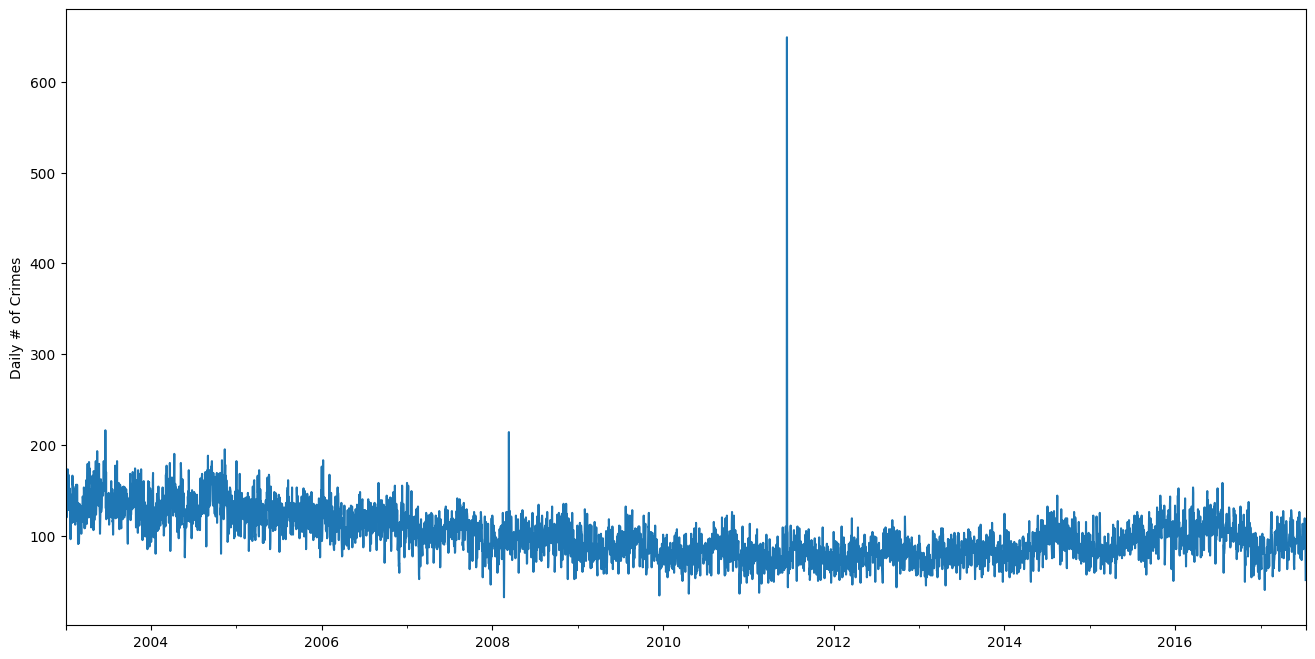

In [9]:
## Plot aggregated daily crimes

df.n_crimes.plot(figsize=(16,8))
plt.ylabel('Daily # of Crimes')
plt.show()

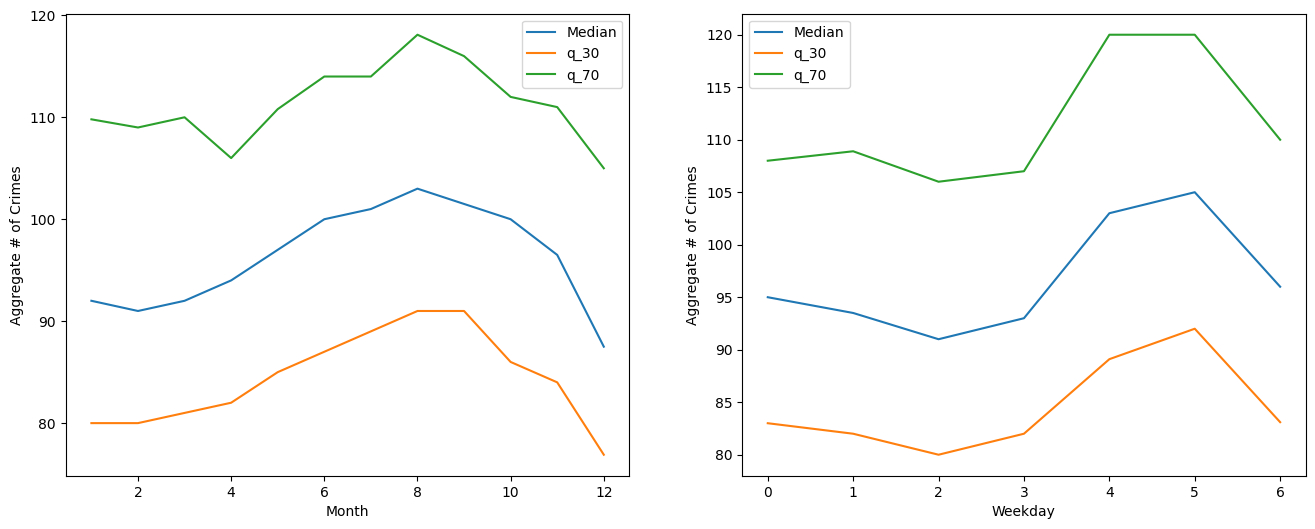

In [10]:
## Plot seasonality  
# 일별 주별로 보았을 때 계절성이 있는것을 알 수 있다. 

plt.figure(figsize=(16,6))

plt.subplot(121)
df.n_crimes.groupby(df.index.month).median().rename('Median').plot(ax=plt.gca(), legend=True)
df.n_crimes.groupby(df.index.month).apply(np.quantile, 0.3).rename('q_30').plot(legend=True)
df.n_crimes.groupby(df.index.month).apply(np.quantile, 0.7).rename('q_70').plot(legend=True)
plt.ylabel('Aggregate # of Crimes'); plt.xlabel('Month')

plt.subplot(122)
df.n_crimes.groupby(df.index.weekday).median().rename('Median').plot(ax=plt.gca(), legend=True)
df.n_crimes.groupby(df.index.weekday).apply(np.quantile, 0.3).rename('q_30').plot(legend=True)
df.n_crimes.groupby(df.index.weekday).apply(np.quantile, 0.7).rename('q_70').plot(legend=True)
plt.ylabel('Aggregate # of Crimes'); plt.xlabel('Weekday')

plt.show()

In [11]:
## Define utility functions

def create_windows(data, window_shape, step = 1, start_id = None, end_id = None):
    
    data = np.asarray(data) #(5308, 1), (5308, 3)
    data = data.reshape(-1,1) if np.prod(data.shape) == max(data.shape) else data #(5308, 1), (5308, 3)
    start_id = 0 if start_id is None else start_id
    end_id = data.shape[0] if end_id is None else end_id
    
    data = data[int(start_id):int(end_id),:] #(5308, 1), (5308, 3)
    window_shape = (int(window_shape), data.shape[-1]) #(21, 1) (21, 3) (7, 3)
    step = (int(step),) * data.ndim
    slices = tuple(slice(None, None, st) for st in step) #slices (slice(None, None, 1), slice(None, None, 1))
    indexing_strides = data[slices].strides #(8, 8)
    win_indices_shape = ((np.array(data.shape) - window_shape) // step) + 1 #[5281    1]
    
    new_shape = tuple(list(win_indices_shape) + list(window_shape)) #(5281, 1, 21, 1)
    strides = tuple(list(indexing_strides) + list(data.strides)) #(8, 8, 8, 8)
    
    window_data = np.lib.stride_tricks.as_strided(data, shape=new_shape, strides=strides)
    return np.squeeze(window_data, 1) #(5281, 21, 1)


class Scaler3D:
    
    def fit(self, X):
        self.mean = X.reshape(-1,X.shape[-1]).mean(0).reshape(1,1,-1)
        self.std = X.reshape(-1,X.shape[-1]).std(0).reshape(1,1,-1)
        return self
        
    def transform(self, X):
        return (X - self.mean) / self.std
    
    def inverse_transform(self, X):
        return (X * self.std) + self.mean

    
def prepare_seq(num_X, cat1_X, cat2_X, scaler=None):
    
    if scaler is not None:
        num_X = scaler.transform(num_X)
        
    inp_dict = {}
    inp_dict['inp_num'] = num_X
    for i,c in enumerate(cat_var):
        inp_dict[f"inp_{c}_cat1"] = cat1_X[:,:,i]
        inp_dict[f"inp_{c}_cat2"] = cat2_X[:,:,i]
    
    return inp_dict

In [12]:
### Split train & test, apply scaler

time_h = 7
window_shape = 21

target = ['n_crimes']
cat_var = ['month','wday','day']

_id_train, _id_valid = train_test_split(np.arange((len(df) - window_shape - time_h + 1)), test_size=0.3, shuffle=False)

_num_X = create_windows(df[target], window_shape=window_shape, end_id=-time_h)
_cat1_X = create_windows(df[cat_var], window_shape=window_shape, end_id=-time_h)
_cat2_X = create_windows(df[cat_var], window_shape=time_h, start_id=window_shape)
_target = create_windows(df[target], window_shape=time_h, start_id=window_shape)

_num_X_train = _num_X[_id_train]; _num_X_valid = _num_X[_id_valid]
_cat1_X_train = _cat1_X[_id_train]; _cat1_X_valid = _cat1_X[_id_valid]
_cat2_X_train = _cat2_X[_id_train]; _cat2_X_valid = _cat2_X[_id_valid]
_target_train = _target[_id_train]; _target_valid = _target[_id_valid]

X_scaler = Scaler3D().fit(_num_X_train)
y_scaler = Scaler3D().fit(_target_train)

X_train = prepare_seq(_num_X_train, _cat1_X_train, _cat2_X_train, scaler=X_scaler)
y_train = y_scaler.transform(_target_train)
X_valid = prepare_seq(_num_X_valid, _cat1_X_valid, _cat2_X_valid, scaler=X_scaler)
y_valid = y_scaler.transform(_target_valid)

In [13]:
### Define Model  

def set_seed(seed):
    
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)


def get_model(param):
    
    set_seed(33)
    
    inp_num = Input((window_shape,1), name='inp_num')
    
    embeddings = {
        'month': Embedding(12+1, param['emb_dim']),
        'wday': Embedding(6+1, param['emb_dim']),
        'day': Embedding(31+1, param['emb_dim'])
    }
    
    inp_cat1, emb_cat = [], []
    for c in cat_var:
        _inp_c1 = Input((window_shape,), name=f"inp_{c}_cat1")
        emb = embeddings[c](_inp_c1)
        inp_cat1.append(_inp_c1)
        emb_cat.append(emb)
    
    enc = Concatenate()([inp_num] + emb_cat)
    enc = LSTM(param['lstm_unit'], return_sequences=False)(enc)
    
    inp_cat2, emb_future = [], []
    for c in cat_var:
        _inp_c2 = Input((time_h,), name=f"inp_{c}_cat2")
        emb = embeddings[c](_inp_c2)
        inp_cat2.append(_inp_c2)
        emb_future.append(emb) 
    
    x = RepeatVector(time_h)(enc)
    dec = Concatenate()([x] + emb_future)
    dec = LSTM(param['lstm_unit'], return_sequences=True)(dec)
    
    output = TimeDistributed(Dense(1))(dec)
    
    model = Model([inp_num] + inp_cat1 + inp_cat2, output)
    model.compile(Adam(lr=param['lr']), 'mse')
    
    return model

In [14]:
## Modeling Fitting  

param_grid = {
    'lstm_unit': [128,64,32], 
    'emb_dim': [8,16,32],
    'lr': [1e-3], ## learning rate
    'epochs': 100, 
    'batch_size': 64
}

es = EarlyStopping(patience=7, verbose=0, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)
hypermodel = get_model
kgs = KerasGridSearch(hypermodel, param_grid, monitor='val_loss', greater_is_better=False, tuner_verbose=1)
kgs.search(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=[es])


9 trials detected for ('lstm_unit', 'emb_dim', 'lr', 'epochs', 'batch_size')



***** (1/9) *****
Search({'lstm_unit': 128, 'emb_dim': 8, 'lr': 0.001, 'epochs': 100, 'batch_size': 64})
SCORE: 0.22043 at epoch 3



***** (2/9) *****
Search({'lstm_unit': 128, 'emb_dim': 16, 'lr': 0.001, 'epochs': 100, 'batch_size': 64})
SCORE: 0.22035 at epoch 2



***** (3/9) *****
Search({'lstm_unit': 128, 'emb_dim': 32, 'lr': 0.001, 'epochs': 100, 'batch_size': 64})
SCORE: 0.22026 at epoch 6



***** (4/9) *****
Search({'lstm_unit': 32, 'emb_dim': 8, 'lr': 0.001, 'epochs': 100, 'batch_size': 64})
SCORE: 0.22023 at epoch 4



***** (5/9) *****
Search({'lstm_unit': 32, 'emb_dim': 16, 'lr': 0.001, 'epochs': 100, 'batch_size': 64})
SCORE: 0.2214 at epoch 10



***** (6/9) *****
Search({'lstm_unit': 32, 'emb_dim': 32, 'lr': 0.001, 'epochs': 100, 'batch_size': 64})
SCORE: 0.22272 at epoch 6



***** (7/9) *****
Search({'lstm_unit': 64, 'emb_dim': 8, 'lr': 0.001, 'epochs': 100, 'batch_size': 64})
SCORE: 0.21898 at epoch 3



***** (8/9) *****
Search({'lstm_unit': 64, 'emb_dim': 16, 'lr': 0.001, 'epochs': 100, 'batch_size': 64})
SCORE: 0.21873 at epoch 10



***** (9/9) *****
Search({'lstm_unit': 64, 'emb_dim': 32, 'lr': 0.001, 'epochs': 100, 'batch_size': 64})
SCORE: 0.21979 at epoch 8


In [15]:
print('BEST PARAM:', kgs.best_params)

BEST PARAM: {'lstm_unit': 64, 'emb_dim': 16, 'lr': 0.001, 'epochs': 10, 'batch_size': 64, 'steps_per_epoch': 58}


In [16]:
## Get predicted values 

pred = np.squeeze(
    y_scaler.inverse_transform(
        kgs.best_model.predict(X_valid)
    ), -1)

y_valid = np.squeeze(y_scaler.inverse_transform(y_valid), -1)

50/50 [==============================] - 3s 10ms/step


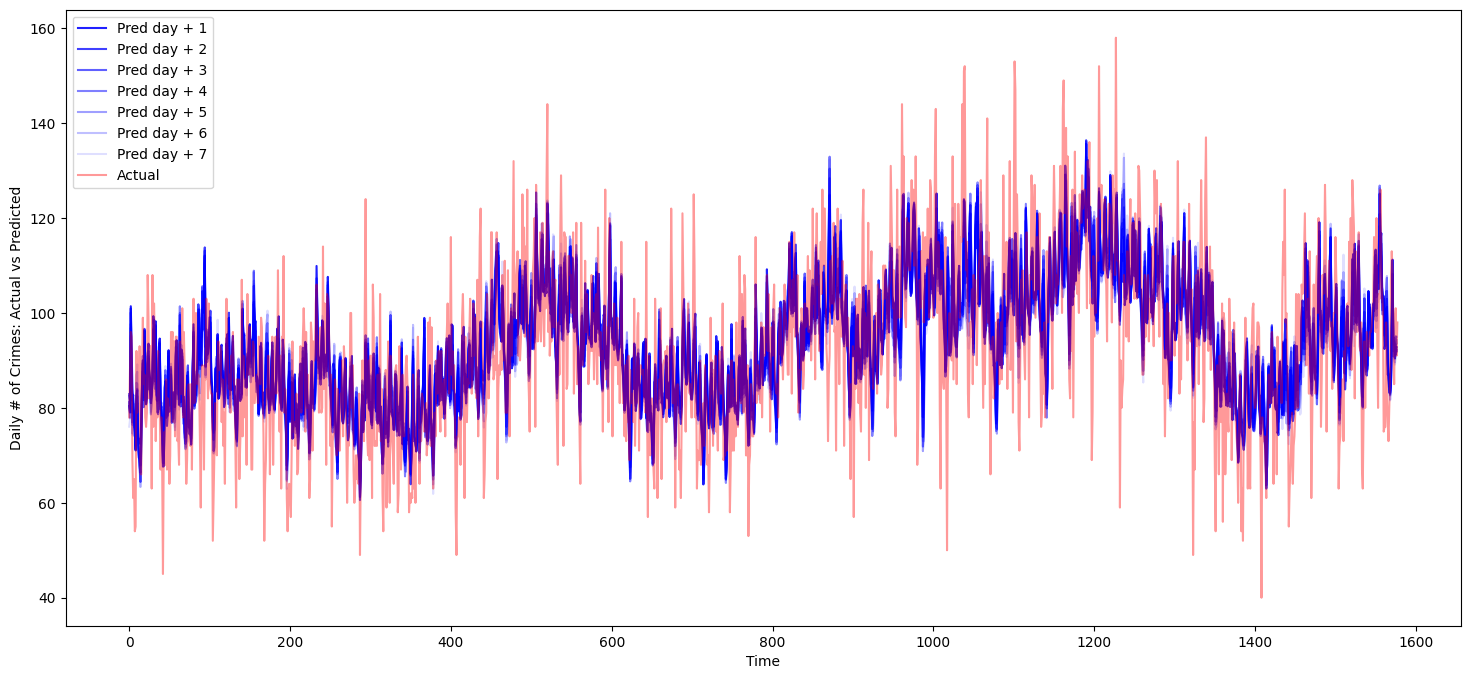

In [17]:
## Visualize Test vs Predicted 
## Test vs prediction values are on different time horizons

plt.figure(figsize=(18,8))

for t_h in range(time_h):
    plt.plot(pred[(time_h-t_h):-(t_h+1),t_h], 
             c='blue', alpha=1-1/(time_h+1)*(t_h+1),
             label=f"Pred day + {t_h+1}")

plt.plot(y_valid[time_h:,0], c='red', alpha=0.4, label='Actual')

plt.ylabel('Daily # of Crimes: Actual vs Predicted')
plt.xlabel('Time')
plt.legend()
plt.show()

In [18]:
## Get model and baseline mse

mse_model = {}
mse_baseline = {}
    
for t_h in range(time_h):

    _mse = mse(y_valid[1:,t_h], y_valid[:-1,0])
    mse_baseline[f"day + {t_h+1}"] = _mse 

    _mse = mse(y_valid[:,t_h], pred[:,t_h])
    mse_model[f"day + {t_h+1}"] = _mse 

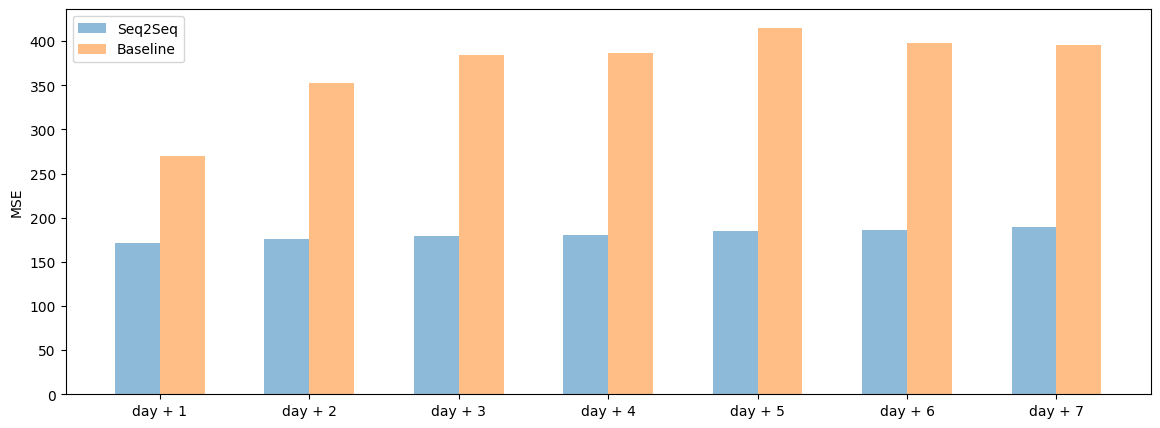

In [19]:
## Plot MSEs 
## MSEs are computed on different time horizons 

plt.figure(figsize=(14,5))

plt.bar(np.arange(len(mse_model))-0.15, mse_model.values(), alpha=0.5, width=0.3, label='Seq2Seq')
plt.bar(np.arange(len(mse_baseline))+0.15, mse_baseline.values(), alpha=0.5, width=0.3, label='Baseline')
plt.xticks(range(len(mse_baseline)), mse_baseline.keys())
plt.ylabel('MSE')
plt.legend()
plt.show()

### 심화 Point: 일반화 극단값(GEV) 분포로 이상치가 높은 시계열 예측값 개선하기

In [20]:
# Extreme Value 적용하기

In [21]:
## Get residuals

t_h = 1 # desired time forecasting horizon to compute the EVA

resid = np.abs(y_valid[:,t_h] - pred[:,t_h])
data = pd.Series(resid, index=(df.iloc[_id_valid[0]:_id_valid[-1]+1]).index, name='resid')

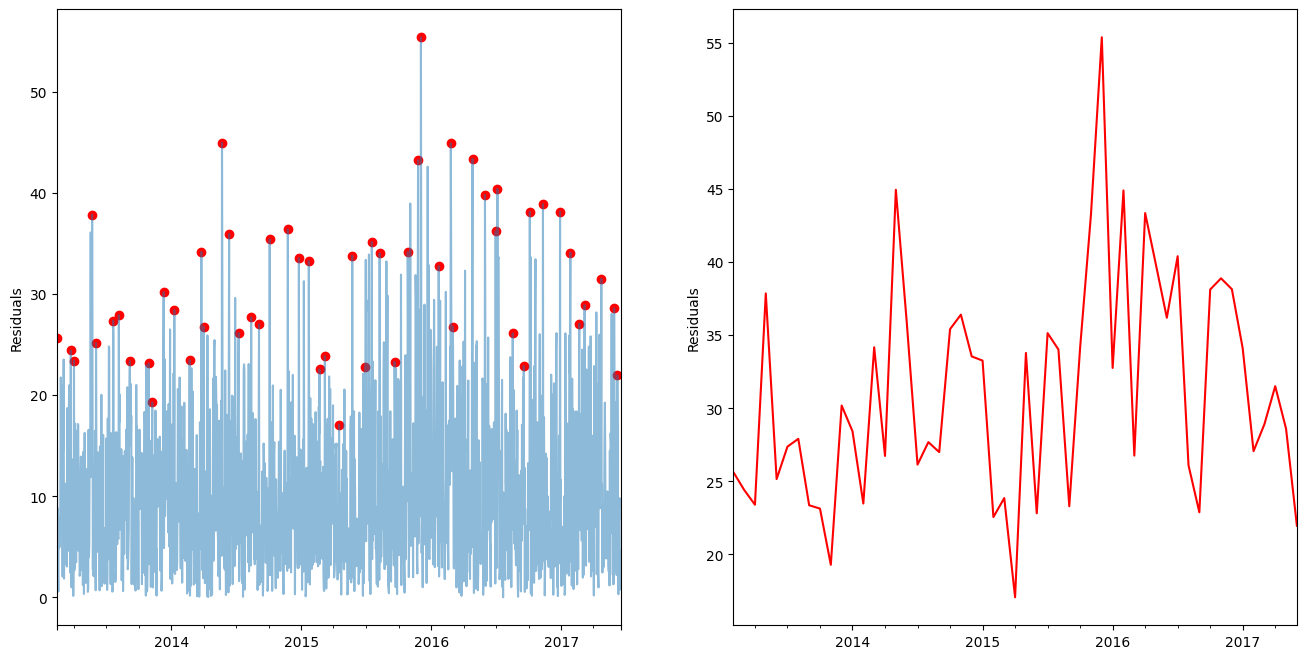

In [22]:
## Plot block maxima

plt.figure(figsize=(16,8))

plt.subplot(121)
data.plot(ax=plt.gca(), alpha=0.5)
plt.scatter(data[data.resample('1M').apply(lambda x: x.idxmax()).values].index, 
            data[data.resample('1M').apply(lambda x: x.idxmax()).values].values, c='red')
plt.ylabel('Residuals')

plt.subplot(122)
data = data.resample('1M').max()
data.plot(ax=plt.gca(), c='red')
plt.ylabel('Residuals')
plt.show()

# 극단값이 언제 발생하냐를 알아야한다.

In [23]:
## Utiliy functions to create bootstrap

def bootstrap_ci(
    data, 
    statfunction=np.average, 
    alpha = 0.05, 
    n_samples = 100):

    def bootstrap_ids(data, n_samples=100):
        for _ in range(n_samples):
            yield np.random.randint(data.shape[0], size=(data.shape[0],))    
    
    alphas = np.array([alpha/2, 1 - alpha/2])
    nvals = np.round((n_samples - 1) * alphas).astype(int)
    # if np.any(nvals < 10) or np.any(nvals >= n_samples-10):
    #     warnings.warn("Some values used extremal samples; results are probably unstable. "
    #                   "Try to increase n_samples")

    data = np.array(data)
    # if np.prod(data.shape) != max(data.shape):
    #     raise ValueError("Data must be 1D")
    data = data.ravel()
    
    boot_indexes = bootstrap_ids(data, n_samples)
    stat = np.asarray([statfunction(data[_ids]) for _ids in boot_indexes])
    stat.sort(axis=0)

    return stat[nvals]

In [24]:
## Get distribution for exreme residuals

f = Fitter(data, distributions=['genextreme','gumbel_r'], bins=20) # 일반화 극단분포(GEV), Gumbel 분포
f.fit()

Fitting 2 distributions: 100%|██████████| 2/2 [00:00<00:00, 13.55it/s]


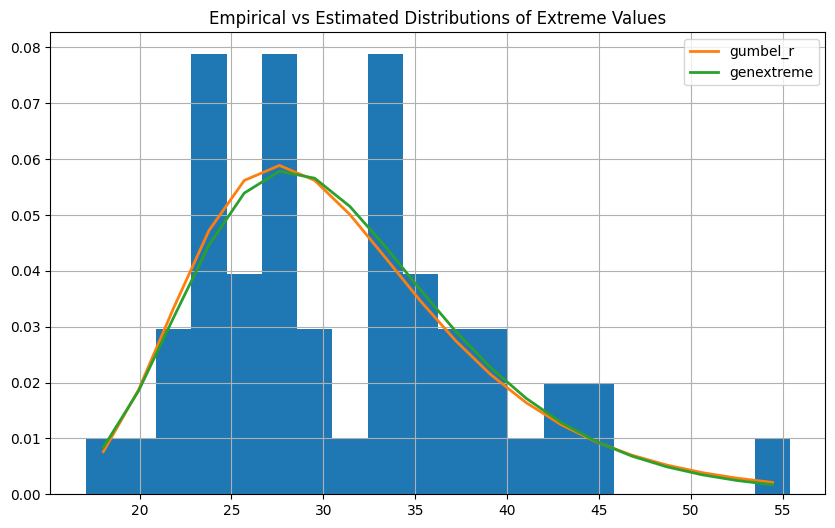

In [25]:
## Plot distribution for extreme residuals
plt.figure(figsize=(10,6))
f.summary()
plt.title('Empirical vs Estimated Distributions of Extreme Values')
plt.show()
# residual이 gumbel 분포를 따른다. 
# 분포를 알았으니 언제(몇일 후에) 범죄율이 최대치로 발생하는지를 알 수 있다.

In [26]:
best_dist = eval(f"stats.{list(f.get_best().keys())[0]}")
f.get_best() # c가 0에 가깝다

{'gumbel_r': {'loc': 27.51407506546997, 'scale': 6.24711838507485}}

In [27]:
## Get estimated params from the best distribution

best_params = best_dist.fit(data)
best_params

(27.51407506546997, 6.24711838507485)

In [28]:
## Calculate bootstrap intervals for the estimted best params

np.random.seed(111)
ci_params = bootstrap_ci(data, best_dist.fit, n_samples=500)
ci_params

array([[25.91522411,  4.96069543],
       [29.43586911,  7.39826766]])

In [29]:
## Define return periods (재현기간) & estimted return values (재현값) 

eps = 1e-1
T = np.arange(1, 1000, eps) + eps # return periods
q = 1-1/T
ppf = best_dist.ppf(q, *best_params) # return values

In [30]:
## Calculate bootstrap intervals for the estimted return values

def gen_ppf(data, q):
    
    new_param = best_dist.fit(data)
    ppf = best_dist.ppf(q, *new_param)
    
    return ppf

np.random.seed(111)
ci_ppf = bootstrap_ci(data, lambda x: gen_ppf(x, q), n_samples=500, alpha=0.05)
ci_ppf

array([[20.53128077, 22.30205577, 23.52627548, ..., 61.22932875,
        61.22984767, 61.23036655],
       [24.13652801, 25.761019  , 27.04862555, ..., 79.14875004,
        79.14948853, 79.15022694]])

### 분석결과 및 해석

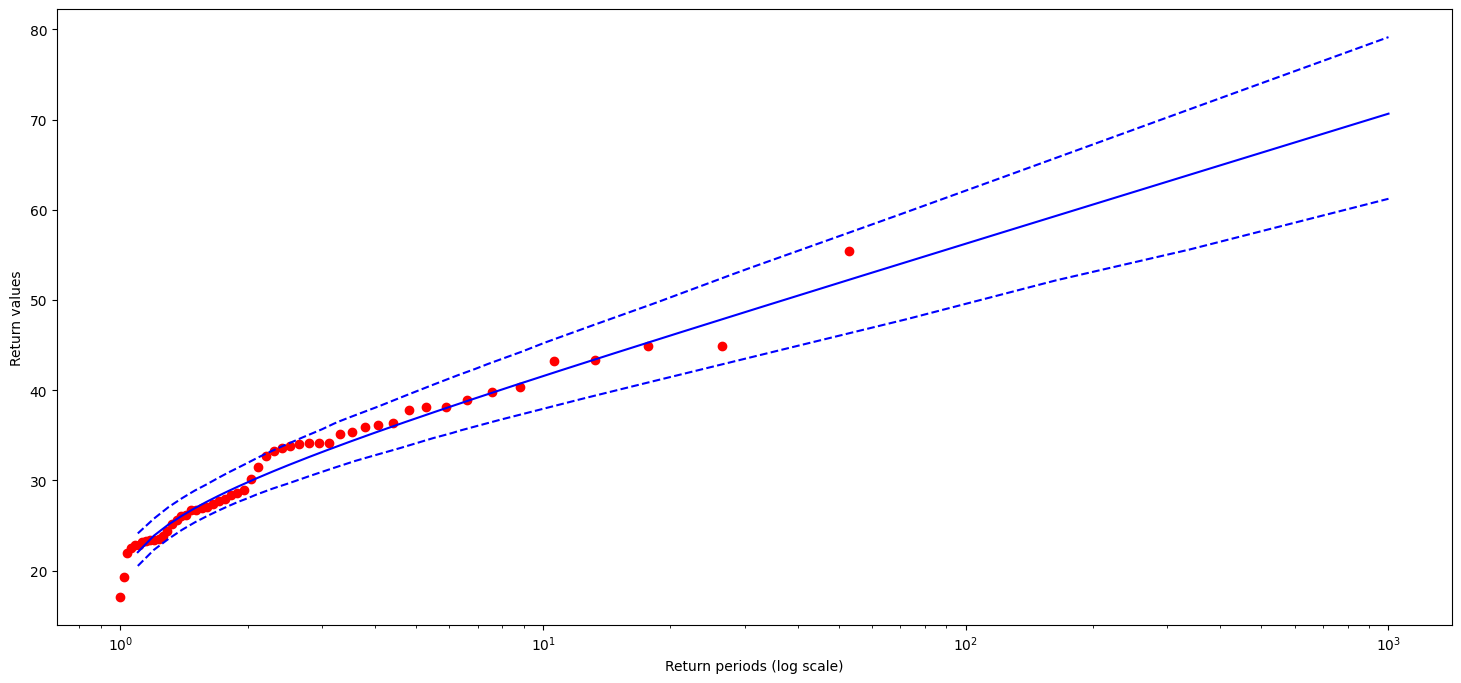

In [31]:
## Plot return values (재현값) 

plt.figure(figsize=(18,8))

plt.semilogx(T, ppf, c='b')
plt.semilogx(T, ci_ppf[0], c='b', linestyle='--')
plt.semilogx(T, ci_ppf[1], c='b', linestyle='--')

N = np.arange(1, len(data)+1)
plt.scatter(N[-1]/N, sorted(data)[::-1], color = 'red')
plt.ylabel('Return values')
plt.xlabel('Return periods (log scale)')
plt.show()
# 파란선 분포의 값
# 빨간선이 return value(재현값)
# 재현값을 가질 수 있는 확률이다. 확률이 낮을 수록 시간이 오래걸린다. 

In [32]:
## Create a summary

eps = 1e-1
T = np.asarray([1, 2, 5, 10, 25, 50, 100]) + eps
q = 1-1/T
ppf = best_dist.ppf(q, *best_params)

np.random.seed(111)
ci_ppf = bootstrap_ci(data, lambda x: gen_ppf(x, q), n_samples=500, alpha=0.05)

summary = pd.DataFrame({
    'return_period':(T-eps).astype(int),
    'lower_ci':ci_ppf[0], 
    'return_value':ppf, 
    'upper_ci':ci_ppf[-1]
}).set_index('return_period')

summary

,lower_ci,return_value,upper_ci
return_period,,,
1,20.531281,22.050399,24.136528
2,28.443648,30.237727,32.464462
5,34.242257,37.022800,40.021628
10,37.997520,41.637921,45.285708
25,42.605439,47.521151,52.014562
50,46.037668,51.902556,57.073901
100,49.593600,56.258027,62.131025
